# Liesel-GAM Demo Notebook

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup and Imports

In [30]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [31]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

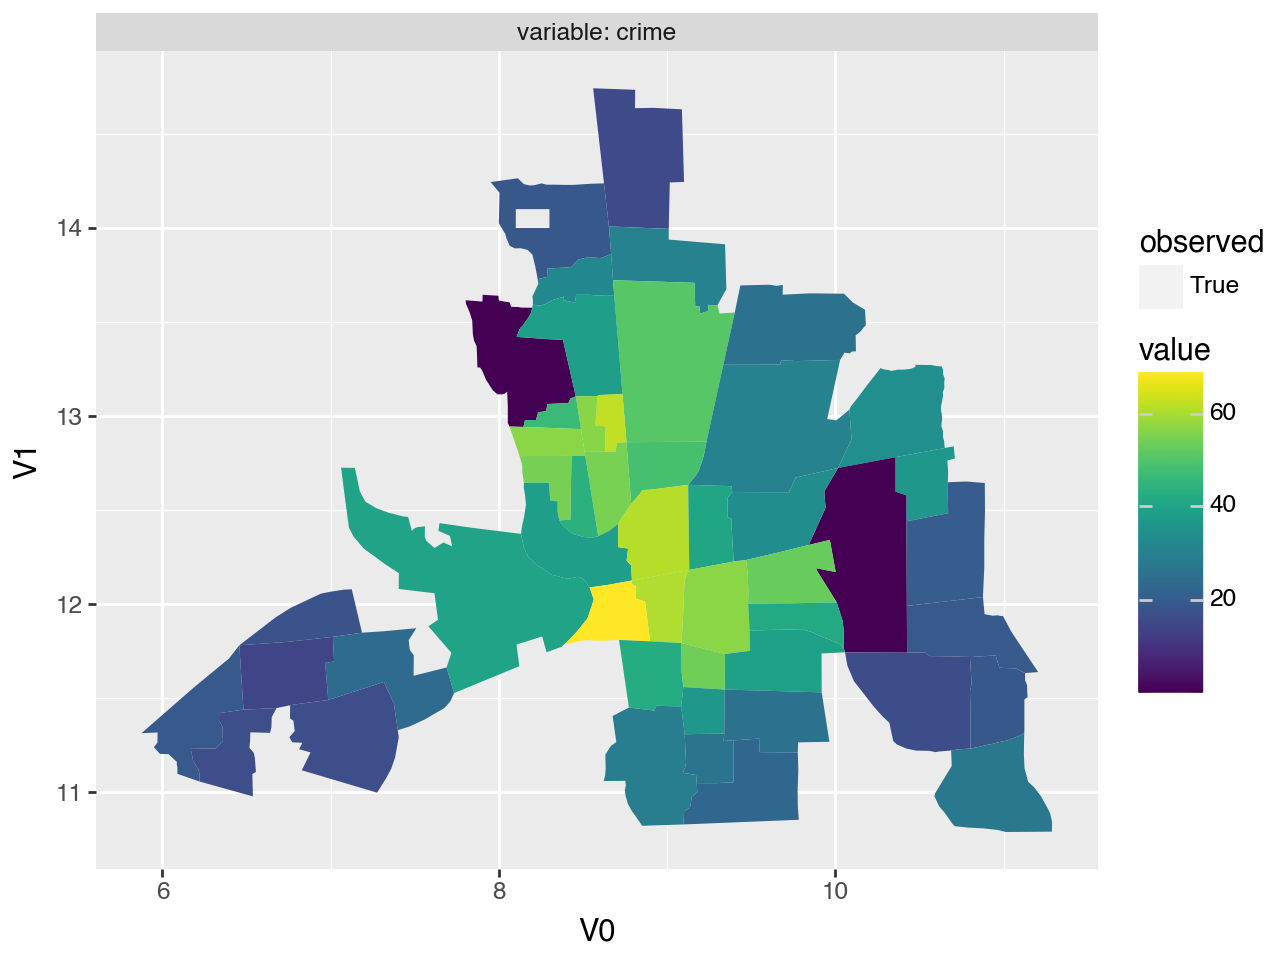

In [32]:
gam.plot_polys(region="district", which=["crime"], df=columb, polys=polys)

## Model Definition

### Setup response model

In [33]:
i = np.arange(columb.shape[0])
i10 = i[:10]
i20 = i[11:20]
i30 = i[21:30]
irest = i[31:]
i = np.concatenate((i10, i20, i30, irest))
df = columb.iloc[i, :].reset_index()

In [34]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

tb = gam.TermBuilder.from_df(df)
loc += tb.mrf(
    "district",
    polys=polys,
    absorb_cons=True,
    diagonal_penalty=True,
    scale_penalty=True,
    noncentered=True,
)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


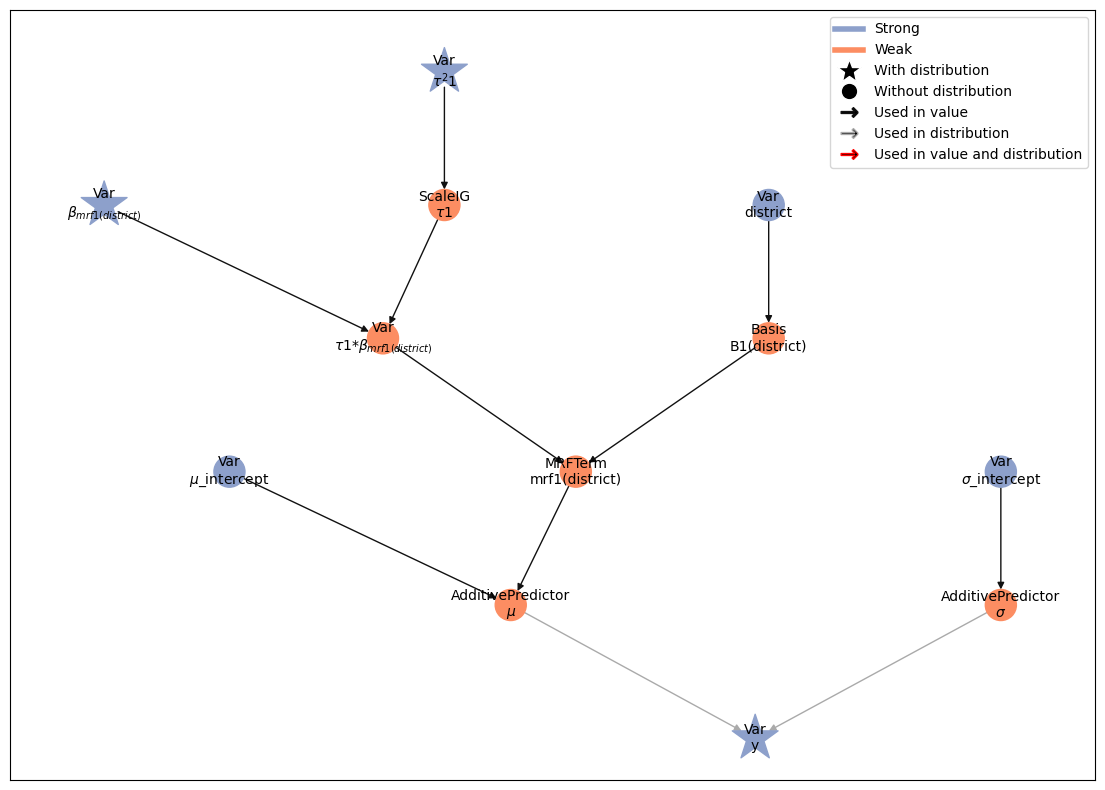

In [35]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [36]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\mu$_intercept', '$\\beta_{mrf1(district)}$', '$\\tau^2$1'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:02<00:00,  6.21chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1240.92chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1512.82chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 0, 0,

### MCMC summary

In [37]:
summary = gs.Summary(results)
summary

Parameter summary:

                                   kernel       mean         sd     q_0.05  \
parameter                index                                               
$\beta_{mrf1(district)}$ (0,)   kernel_02   0.130147   1.023441  -1.591268   
                         (1,)   kernel_02   0.007013   0.995691  -1.622860   
                         (2,)   kernel_02   0.120693   0.994212  -1.517827   
                         (3,)   kernel_02   0.186515   1.011930  -1.496145   
                         (4,)   kernel_02   0.029556   0.966147  -1.572371   
                         (5,)   kernel_02  -0.022804   0.971040  -1.613086   
                         (6,)   kernel_02  -0.005921   1.005340  -1.666011   
                         (7,)   kernel_02  -0.008003   0.947100  -1.535210   
                         (8,)   kernel_02   0.034140   0.978856  -1.587156   
                         (9,)   kernel_02  -0.168110   1.030852  -1.858731   
                         (10,)  kernel_02   0.101670   0.987258  -1.513662   
                         (11,)  kernel_02  -0.100319   0.987709  -1.742948   
                         (12,)  kernel_02   0.041901   0.962715  -1.548947   
                         (13,)  kernel_02  -0.062339   0.954298  -1.608388   
                         (14,)  kernel_02  -0.007854   0.965407  -1.595250   
                         (15,)  kernel_02  -0.193521   1.048594  -1.927470   
                         (16,)  kernel_02   0.065601   0.990368  -1.552719   
                         (17,)  kernel_02  -0.008219   0.969226  -1.618287   
                         (18,)  kernel_02   0.058934   0.990007  -1.553303   
                         (19,)  kernel_02   0.101800   0.994637  -1.590527   
                         (20,)  kernel_02  -0.078601   0.962491  -1.651731   
                         (21,)  kernel_02  -0.316325   1.059373  -2.055573   
                         (22,)  kernel_02  -0.051486   0.957341  -1.613547   
                         (23,)  kernel_02   0.022932   0.978560  -1.582284   
                         (24,)  kernel_02   0.093995   0.997301  -1.525558   
                         (25,)  kernel_02   0.071414   0.962123  -1.550850   
                         (26,)  kernel_02   0.054374   0.998530  -1.556362   
                         (27,)  kernel_02  -0.077896   0.970964  -1.672116   
                         (28,)  kernel_02  -0.127474   0.982140  -1.685807   
                         (29,)  kernel_02   0.094836   0.974701  -1.545034   
                         (30,)  kernel_02  -0.112596   0.965568  -1.696113   
                         (31,)  kernel_02   0.014887   0.968951  -1.580877   
                         (32,)  kernel_02   0.152819   0.992329  -1.478284   
                         (33,)  kernel_02   0.125698   0.996217  -1.537175   
                         (34,)  kernel_02  -0.088842   0.963747  -1.658309   
                         (35,)  kernel_02   0.124586   0.952838  -1.462961   
                         (36,)  kernel_02  -0.208848   0.955620  -1.742750   
                         (37,)  kernel_02  -0.035289   0.984614  -1.659492   
                         (38,)  kernel_02  -0.026598   0.963753  -1.613868   
                         (39,)  kernel_02   0.181338   0.975592  -1.453259   
                         (40,)  kernel_02   0.268785   1.030613  -1.501547   
                         (41,)  kernel_02   0.234860   0.984739  -1.453334   
                         (42,)  kernel_02  -0.368494   1.047270  -2.004781   
                         (43,)  kernel_02  -0.206793   0.950373  -1.704017   
                         (44,)  kernel_02   0.503227   1.072569  -1.312553   
                         (45,)  kernel_02  -0.572446   1.086177  -2.198616   
                         (46,)  kernel_02   0.168907   0.914730  -1.433397   
                         (47,)  kernel_02   0.467188   0.915899  -1.198401   
$\mu$_intercept          ()     kernel_01  34.771038   2.359603  30.872315   
$\

## Plots

In [38]:
samples = results.get_posterior_samples()

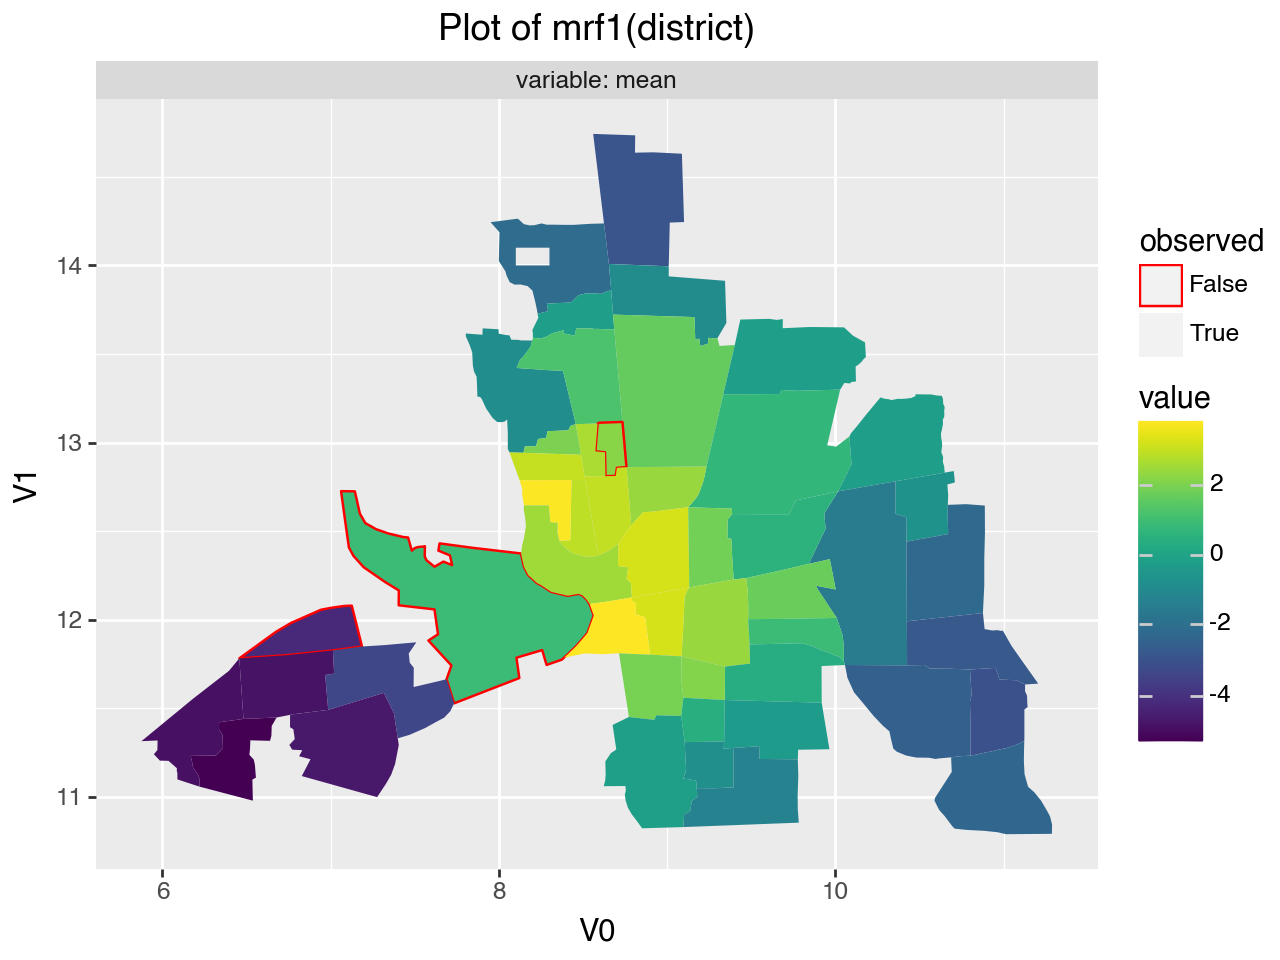

In [39]:
gam.plot_regions(term=loc.terms["mrf1(district)"], samples=samples, polys=polys)

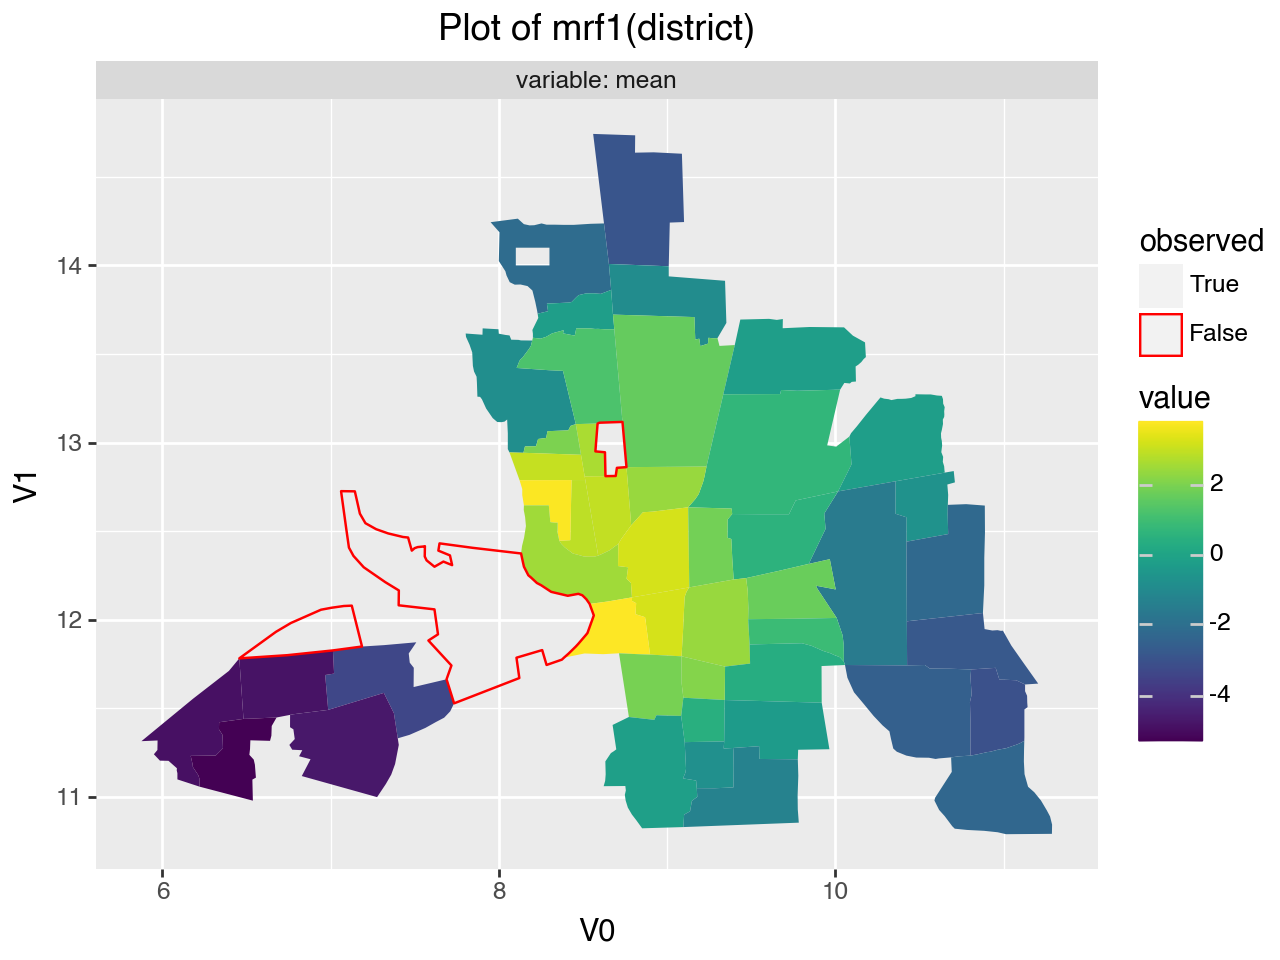

In [40]:
gam.plot_regions(
    term=loc.terms["mrf1(district)"],
    samples=samples,
    polys=polys,
    show_unobserved=False,
    unobserved_color="red",
    observed_color="none",
)

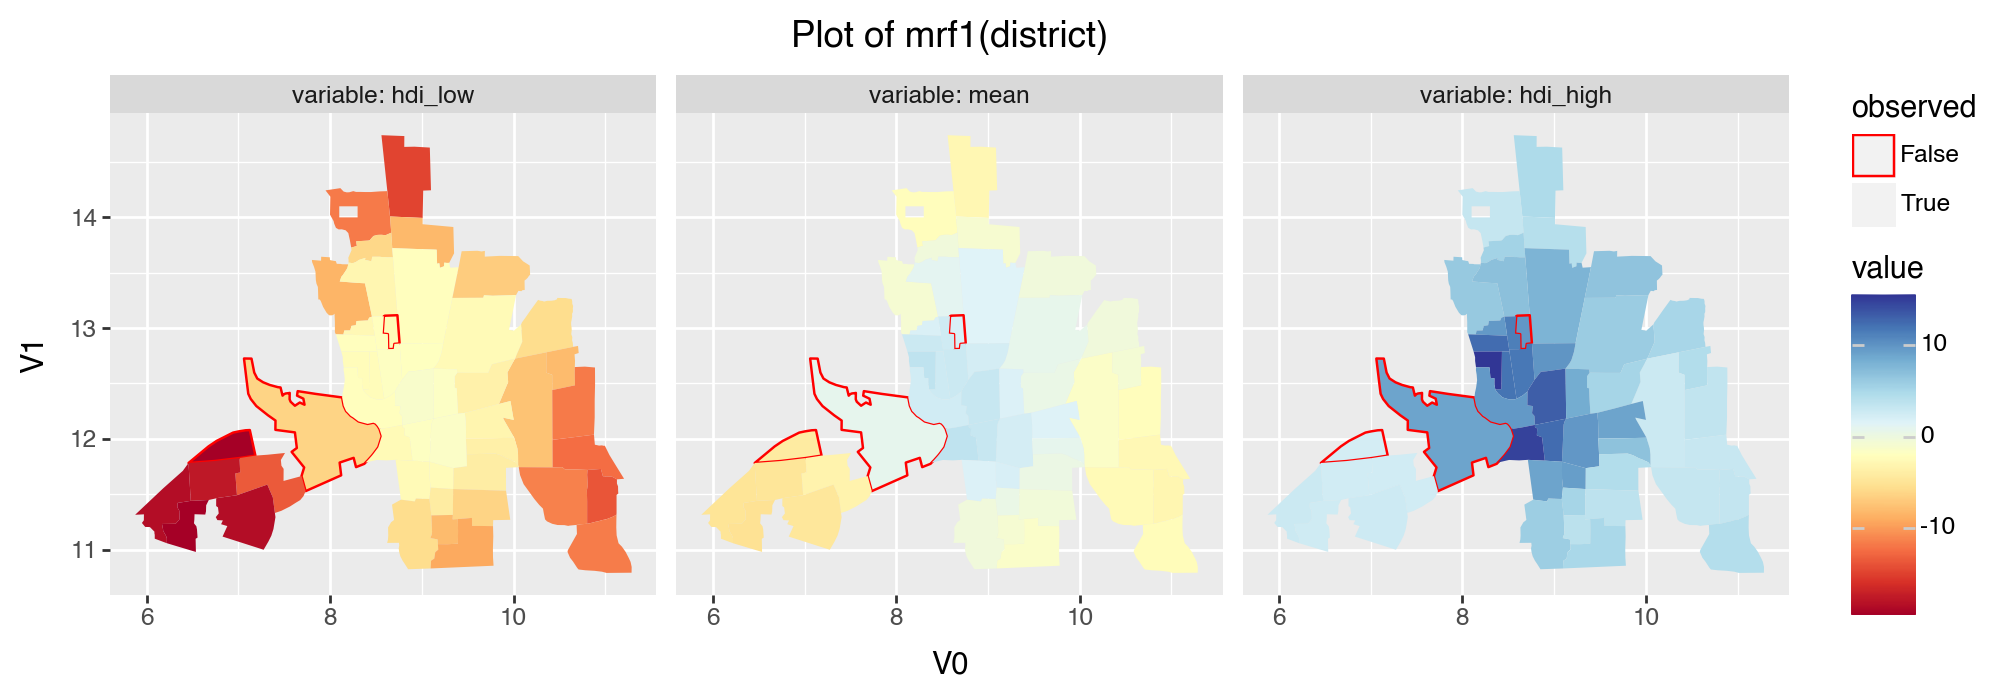

In [41]:
import plotnine as p9

(
    gam.plot_regions(
        term=loc.terms["mrf1(district)"],
        samples=samples,
        polys=polys,
        which=["hdi_low", "mean", "hdi_high"],
        observed_color="none",
        unobserved_color="red",
        # show_unobserved=False
    )
    + p9.theme(figure_size=(10, 3.5))
    + p9.scale_fill_cmap("RdYlBu")
)

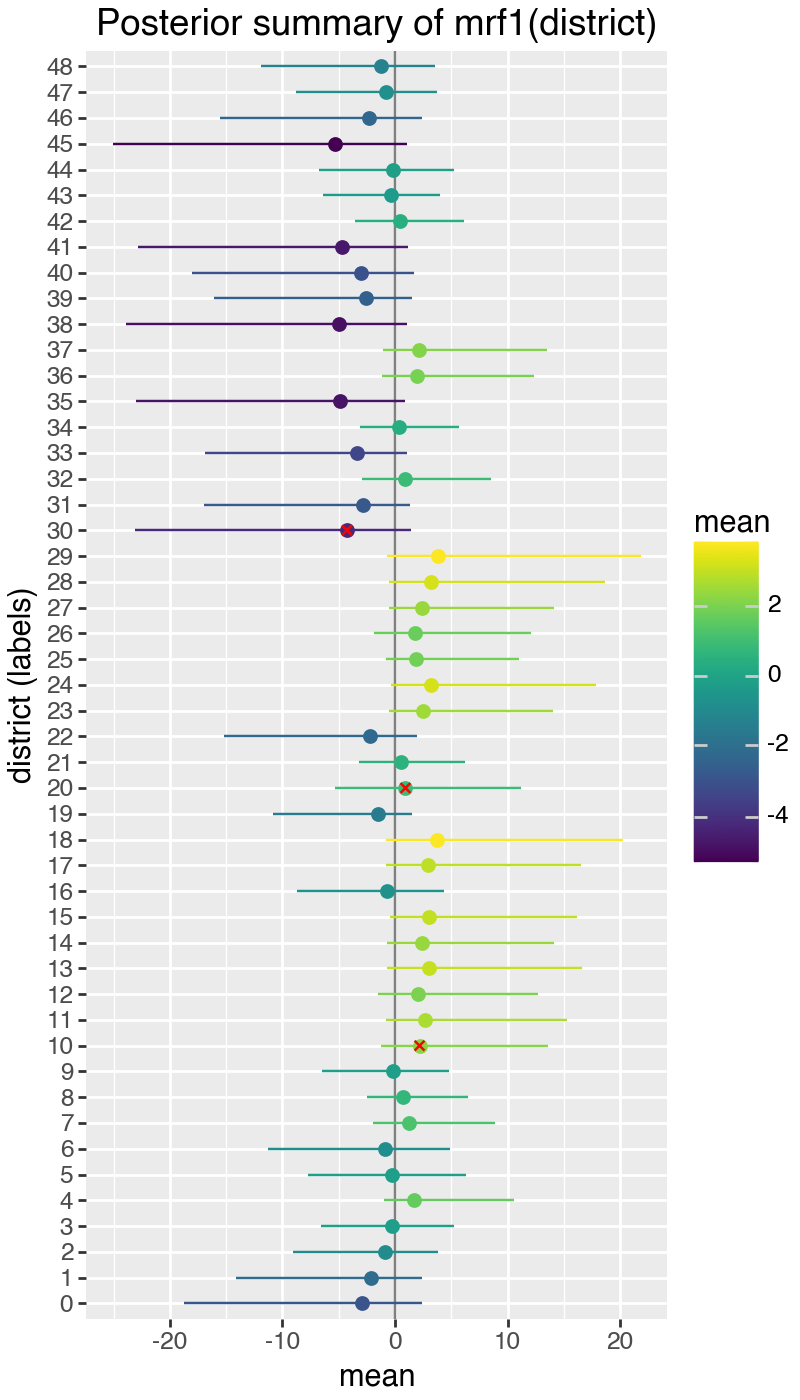

In [42]:
gam.plot_forest(
    term=loc.terms["mrf1(district)"],
    samples=samples,
    ymin="q_0.05",
    ymax="q_0.95",
    show_unobserved=True,
) + p9.theme(figure_size=(4, 7))